In [30]:
# библиотеки....
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


ЧТЕНИЕ И НОРМИРОВАНИЕ ДАННЫХ ИСХОДНОЙ ТАБЛИЦЫ

In [3]:
df = pd.read_csv('/content/drive/My Drive/Bases/makhachkala_weather_2011_2020_2.csv')

In [4]:
# нормируем столбцы (6 столбцов), которые по условию задачи
# участвуют в формировании вектора X
x_cols = ['t_air', 'rel_hum', 'P_atm', 'precip', 'wind_dir', 'wind_speed']

# нормировка данных по каждому столбцу к интервалу [0..1]
for col in x_cols:
  m = max(df[col])
  df[col] = df[col] / m

df

,datetime,t_air,t_soil,t_dew,P_part_water,rel_hum,satur_def,P_atm,precip,wind_dir,wind_speed,shower,snow,fog,strong_wind
0,2011-01-01 00:00:00,0.170984,7.0,5.5,9.01,0.93,0.73,0.970389,0.0,0.833333,0.1875,0,0,0,0
1,2011-01-01 03:00:00,0.160622,6.0,5.1,8.75,0.92,0.73,0.969437,0.0,0.861111,0.2500,0,0,0,0
2,2011-01-01 06:00:00,0.150259,6.0,4.9,8.64,0.94,0.58,0.969723,0.0,0.916667,0.1875,0,0,0,0
3,2011-01-01 09:00:00,0.152850,7.0,3.8,8.00,0.86,1.28,0.969628,0.0,0.861111,0.3750,0,0,0,0
4,2011-01-01 12:00:00,0.134715,6.0,3.0,7.58,0.86,1.26,0.970199,0.0,0.888889,0.3750,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29219,2020-12-31 09:00:00,0.111399,6.0,1.8,7.01,0.84,1.33,0.977625,0.0,0.886111,0.1875,0,0,0,0
29220,2020-12-31 12:00:00,0.121762,6.0,2.4,7.29,0.85,1.29,0.976959,0.0,0.802778,0.1250,0,0,0,0
29221,2020-12-31 15:00:00,0.113990,5.0,2.0,7.09,0.85,1.25,0.976673,0.0,0.905556,0.0625,0,0,1,0
29222,2020-12-31 18:00:00,0.119171,2.0,2.0,7.07,0.83,1.45,0.980577,0.0,0.433333,0.1875,0,0,0,0


ФУНКЦИЯ ГЕНЕРАЦИИ ВЫБОРКИ 

In [14]:
# data - исходный датафрейм
# days_count - размер блока данных для X примера (по умолчанию 1 день)
# x_col_names - список колонок c которых генерируются векторы X
# y_col_name - колонка для генерации значений Y

def CreateSamples(data, x_col_names, y_col_name, days_count=1):
  
  block_size = days_count * 8 # размер блока данных

  pos = 0 # начальная позиция текущего смещения в датасете

  # обнуляем списки, отдельно для 0 и 1
  samples_x_0 = []
  samples_x_1 = []
    
  Ex = False

  while not Ex: # цикл остановится, когда переменная Ex станет истиной 

    if pos + block_size < data.shape[0]: # если не дошли до конца....

      x_vec = []
      for x_col_name in x_col_names:
        x_vec.extend(data[x_col_name][pos:pos+block_size].to_list())
      
      # отделяем примеры с 0 и 1 в отдельные выборки
      if data[y_col_name][pos+block_size:pos+block_size+1].to_list()[0] == 0:
        samples_x_0.append(x_vec)
      else:
        samples_x_1.append(x_vec)        

    else:

      Ex = True
    
    pos += 1 # сдвигаем позицию на 1

  # перевод данных в numpy массивы
  samples_x_0 = np.array(samples_x_0)
  samples_x_1 = np.array(samples_x_1)  

  return samples_x_0, samples_x_1


ГЕНЕРАЦИЯ ВЫБОРКИ

In [28]:
# размер блока данных
days_count = 7

# генерация выборки 
samples_x_0, samples_x_1 = CreateSamples(df, x_cols, 'fog', days_count)

# рамерность массивов
print(samples_x_0.shape)
print(samples_x_1.shape)

(28836, 336)
(332, 336)


МОДЕЛЬ НЕЙРОННОЙ СЕТИ (АВТОКОДИРОВЩИК)

In [31]:
# days_count - размер блока данных в днях

def CreateModel(days_count):

  input = Input((days_count*8*6,))
  
  x = Dense(512, activation='relu')(input)
  x = Dense(256, activation='relu')(x)  
  x = Dense(128, activation='relu')(x)  
  x = Dense(64, activation='relu')(x)  
  x = Dense(32, activation='relu')(x)  
  x = Dense(64, activation='relu')(x)  
  x = Dense(128, activation='relu')(x)  
  x = Dense(256, activation='relu')(x)  
  x = Dense(512, activation='relu')(x)  
              
  output = Dense(days_count*8*6, activation='sigmoid')(x) 
  
  return Model(input, output) 

CALLBACK для фиксации лучшего обучения

In [24]:
# файл для сохранения лучших весов модели
model_save_file = '/content/drive/My Drive/Bases/model_best_f_ae.h5'

# коллбэк для фиксации лучших результатов обучения...

class MyCallback(Callback):
  
  # инициализация
  def __init__(self, model):
    self.model = model
    # начальный счет по метрике
    self.best_loss = 1000000.0
       
  # окончание каждой эпохи....
  def on_epoch_end(self, epoch, logs=None):
    if logs['val_loss'] < self.best_loss:
      self.best_loss = logs['val_loss']
      print('\n\n!!!!!!!!Лучший val_loss =', self.best_loss, '\n')
      self.model.save_weights(model_save_file)   

  # в конце обучения
  def on_train_end(self, logs=None):
    print('\n\n!ЛУЧШИЙ val_loss ОБУЧЕНИЯ =', self.best_loss, '\n')

ПАРАМЕТРЫ ОБУЧЕНИЯ

In [39]:
# параметры обучения
batch_size = 50

epochs_count = 100

learning_rate = 1e-3

ОБУЧЕНИЕ НЕЙРОННОЙ СЕТИ

In [29]:
# деление выборки на обучающую и проверочную
x_train, x_val, _, _ = train_test_split(samples_x_0, samples_x_0, 
                                        test_size=0.01152, random_state=1)
del samples_x_0

print(x_train.shape)
print(x_val.shape)
print(samples_x_1.shape)

(28503, 336)
(333, 336)
(332, 336)


In [40]:
# создание модели
model = CreateModel(days_count=days_count)  
cb = MyCallback(model)

In [41]:
# компиляция
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='mean_squared_error')
# обучение
history = model.fit(x_train, x_train, 
                    batch_size = batch_size,
                    epochs= epochs_count, 
                    validation_data=(x_val, x_val),
                    verbose=1,
                    callbacks=[cb])

Epoch 1/100
565/571 [============================>.] - ETA: 0s - loss: 0.0210

!!!!!!!!Лучший val_loss = 0.017480414360761642 

571/571 [==============================] - 3s 4ms/step - loss: 0.0209 - val_loss: 0.0175
Epoch 2/100
565/571 [============================>.] - ETA: 0s - loss: 0.0161

!!!!!!!!Лучший val_loss = 0.01612541638314724 

571/571 [==============================] - 2s 4ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 3/100
557/571 [============================>.] - ETA: 0s - loss: 0.0140

!!!!!!!!Лучший val_loss = 0.014412145130336285 

571/571 [==============================] - 2s 4ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 4/100
571/571 [==============================] - ETA: 0s - loss: 0.0127

!!!!!!!!Лучший val_loss = 0.012620395049452782 

571/571 [==============================] - 2s 4ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 5/100
571/571 [==============================] - 2s 3ms/step - loss: 0.0119 - val_loss: 0.0128
Epoch 6/100
566/571 [===========

АРХИТЕКТУРА МОДЕЛИ

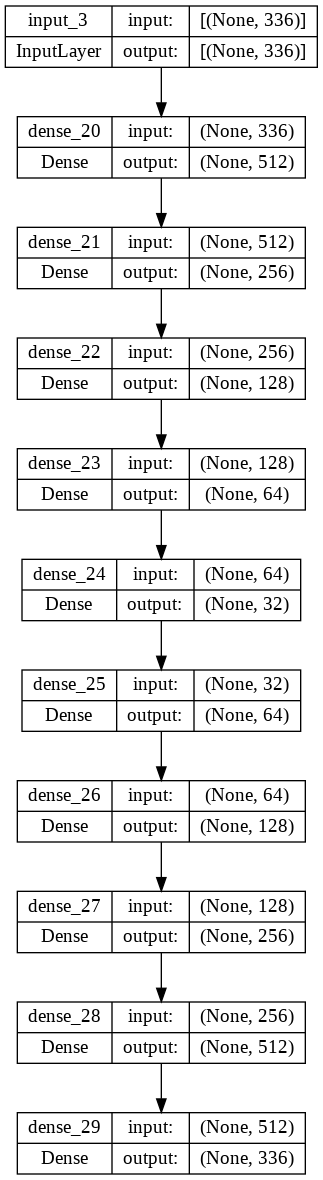

In [42]:
plot_model(model, show_shapes=True, show_layer_names=True)

ГРАФИКИ ОБУЧЕНИЯ

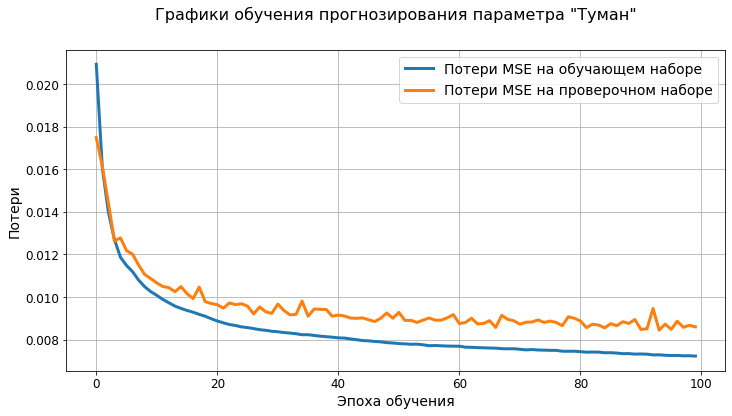

In [43]:
# графики обучения
def cm_to_inch(value):
    return value/2.54

plt.figure(figsize=(cm_to_inch(30),cm_to_inch(15)))

plt.title('Графики обучения прогнозирования параметра "Туман"', 
          pad=30, fontsize=16)

plt.plot(history.history['loss'], 
         label='Потери MSE на обучающем наборе', linewidth=3)
plt.plot(history.history['val_loss'], 
         label='Потери MSE на проверочном наборе', linewidth=3)

plt.xlabel('Эпоха обучения', fontsize=14)
plt.ylabel('Потери', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

АНАЛИЗ РЕЗУЛЬТАТОВ

In [44]:
# пропускаем через автокодировщик все данные, где 1
x_pred_1 = model.predict(samples_x_1)

# считаем массив потерь
x_loss_1 = np.mean(np.power(samples_x_1 - x_pred_1, 2), axis=1)
print(x_loss_1.shape)

# min-max ошибка
print(min(x_loss_1))
print(max(x_loss_1))

11/11 [==============================] - 0s 2ms/step
(332,)
0.0017915034997728462
0.021972590467193506


In [45]:
# пропускаем через автокодировщик проверочные данные, где 0
x_pred_0 = model.predict(x_val)

# считаем массив потерь
x_loss_0 = np.mean(np.power(x_val - x_pred_0, 2), axis=1)
print(x_loss_0.shape)

# min-max ошибка
print(min(x_loss_0))
print(max(x_loss_0))

11/11 [==============================] - 0s 2ms/step
(333,)
0.001565785299825494
0.018009267337931272


In [57]:
bias = 0.00826
print('Процент правильно распознанных 0:', sum(x_loss_0 <= bias) / len(x_loss_0))
print('Процент правильно распознанных 1:', sum(x_loss_1 > bias) / len(x_loss_1))

Процент правильно распознанных 0: 0.5015015015015015
Процент правильно распознанных 1: 0.5
